✅ Normalized dataset is ready!
Found 13685 images belonging to 3 classes.
Found 3419 images belonging to 3 classes.
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - accuracy: 0.5206 - loss: 1.1211 - val_accuracy: 0.6993 - val_loss: 0.6898
Epoch 2/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 581s 1s/step - accuracy: 0.6307 - loss: 0.8710 - val_accuracy: 0.7087 - val_loss: 0.6520
Epoch 3/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 578s 1s/step - accuracy: 0.6624 - loss: 0.7871 - val_accuracy: 0.6990 - val_loss: 0.6450
Epoch 4/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 649s 1s/step - accuracy: 0.6880 - loss: 0.7158 - val_accuracy: 0.7063 - val_loss: 0.6353
Epoch 5/5
428/428 ━━━━━━━━━━━━━━━━━━━━ 586s 1s/step - accuracy: 0.7095 - loss: 0.6738 - val_accuracy: 0.6944 - val_loss: 0.6399


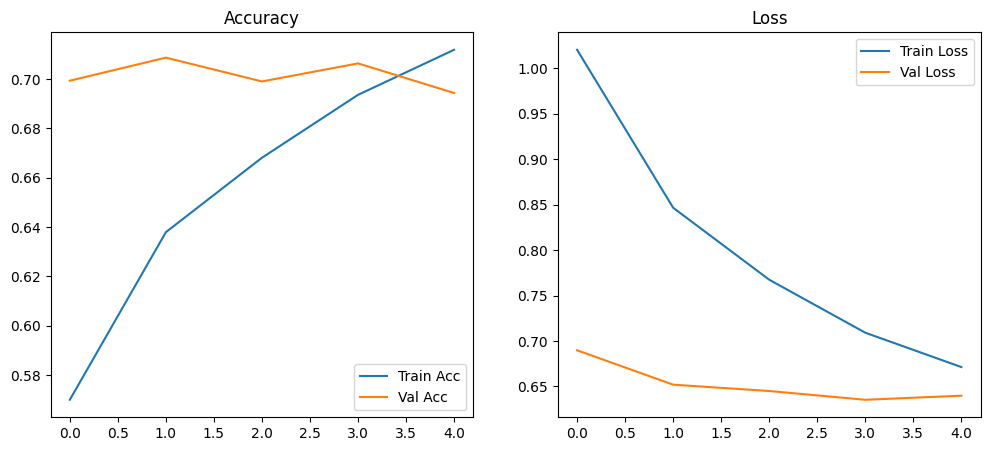

107/107 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step
🔍 Classification Report:

              precision    recall  f1-score   support

   1NonCOVID       0.70      0.94      0.81      1378
      2COVID       0.71      0.56      0.63      1518
        3CAP       0.59      0.42      0.49       523

    accuracy                           0.69      3419
   macro avg       0.67      0.64      0.64      3419
weighted avg       0.69      0.69      0.68      3419



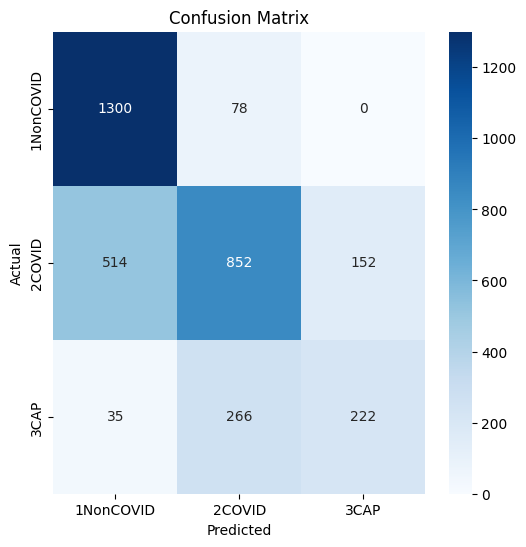

107/107 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.8514 - loss: 0.3729
✅ Final Accuracy: 0.6944
❌ Error Rate: 30.56%


In [3]:
# ✅ Unzip Normalized Dataset
import zipfile

with zipfile.ZipFile("normalized_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/normalized_dataset")

print("✅ Normalized dataset is ready!")

# 🧪 Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 📁 Dataset paths
data_path = "/content/normalized_dataset/curated_data"
img_size = 160
batch_size = 32

# 🔄 Data generators
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_data = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)

# 🔧 NASNetMobile model
base_model = NASNetMobile(include_top=False, input_shape=(img_size, img_size, 3), weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# 🚀 Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 🏋 Train
history = model.fit(train_data, validation_data=val_data, epochs=5)

# 💾 Save
model.save("NASNetMobile_COVID_CT.h5")

# 📉 Plot history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

# 📊 Evaluation
val_data.reset()
predictions = model.predict(val_data, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_data.classes
class_labels = list(val_data.class_indices.keys())

print("🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 📉 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 📌 Accuracy & Error
final_loss, final_acc = model.evaluate(val_data)
error_rate = (1 - final_acc) * 100
print(f"✅ Final Accuracy: {final_acc:.4f}")
print(f"❌ Error Rate: {error_rate:.2f}%")
